### Runnning inference and methods that measure the uncertainty (post training)
For inference we need
1. Load the model
2. Load data
3. Visulize, lets see what is out there for NuScenes

In [1]:
import os, sys
sys.path.insert(0, "/home/image/ohs/Det3D")
import torch

import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import nuscenes
from nuscenes.nuscenes import NuScenes

# Importing from Det3D
from det3d.torchie import Config
from det3d.datasets import build_dataset, build_dataloader
from det3d.torchie.trainer.trainer import example_to_device

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # single GPU

In [3]:
#file_path="/home/image/ohs/Det3D/examples/cbgs/configs/inference_uncertainty_config.py"
file_path ="/home/image/ohs/Det3D/examples/cbgs/configs/nusc_all_vfev3_spmiddleresnetfhd_rpn2_mghead_syncbn.py"
cfg = Config.fromfile(file_path)

In [4]:
nusc_val_dataset = build_dataset(cfg.data.val)
nusc_val_loader =  build_dataloader(nusc_val_dataset, 2,1, dist=False)
nusc = NuScenes(version=nusc_val_dataset.version, dataroot=str(nusc_val_dataset._root_path), verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 43.9 seconds.
Reverse indexing ...
Done reverse indexing in 13.8 seconds.


In [5]:
A = next(iter(nusc_val_loader))
example = example_to_device(A, torch.cuda.current_device(), non_blocking=False)

In [6]:
# ego_pose contains information about the location (encoded in translation) and the orientation (encoded in rotation) 
# of the ego vehicle body frame, with respect to the global coordinate system.
print(len(nusc.ego_pose), len(nusc.sample_data))
nusc.ego_pose[0].keys()

2631083 2631083


dict_keys(['token', 'timestamp', 'rotation', 'translation'])

In [7]:
sample = nusc.sample[20]
print(sample.keys())
print(sample['data'])
print(nusc.get('sample_data', sample['data']['LIDAR_TOP'])['is_key_frame'])
print(nusc.get('sample_data', nusc.get('sample', sample['next'])['data']['LIDAR_TOP'])['is_key_frame'])

dict_keys(['token', 'timestamp', 'prev', 'next', 'scene_token', 'data', 'anns'])
{'RADAR_FRONT': '516bfb53b8ca4eab8f0401471722932a', 'RADAR_FRONT_LEFT': 'ee90f17b44aa479d811006ca70f56180', 'RADAR_FRONT_RIGHT': '9a99ce3c845146bd93b80489e51291c2', 'RADAR_BACK_LEFT': 'f1f918b57e0b441c9a41a2e7d2b9b72d', 'RADAR_BACK_RIGHT': '5e21742e01484635bacb0b5de9f3dac2', 'LIDAR_TOP': '946b839480be46a3ae1ddcb359079f6d', 'CAM_FRONT': 'a59c061fc9b7488693b91d0bab13acf1', 'CAM_FRONT_RIGHT': '5a331ab3acfb420ebf3c7f7700690f68', 'CAM_BACK_RIGHT': '8fa9938924be4f9d9788e74eb0e51b59', 'CAM_BACK': 'c3dd2544a7624f6d80aba31be6b92226', 'CAM_BACK_LEFT': 'c792b2920d024582b4640f6447bb7a98', 'CAM_FRONT_LEFT': '3e8218fd5e23498b8b11d65d2d34f15a'}
True
True


In [8]:
print(len(nusc.sample_data)) # 2631083 / 34149
print(nusc.sample_data[0].keys())
len(nusc.field2token("sample_data", "sample_token", sample['token']))

2631083
dict_keys(['token', 'sample_token', 'ego_pose_token', 'calibrated_sensor_token', 'timestamp', 'fileformat', 'is_key_frame', 'height', 'width', 'filename', 'prev', 'next', 'sensor_modality', 'channel'])


80

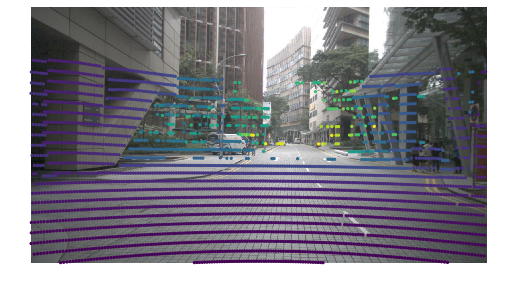

In [9]:
nusc.render_pointcloud_in_image(example['metadata'][0]['token'], pointsensor_channel='LIDAR_TOP')
# nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP')

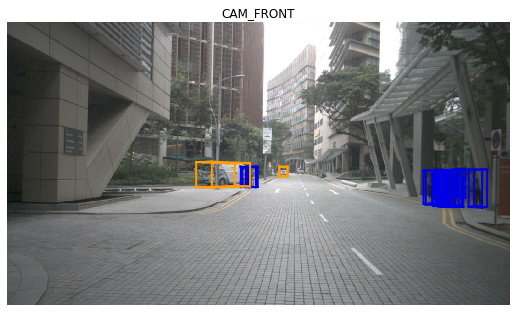

In [10]:
sample = nusc.get('sample', example['metadata'][0]['token'])
nusc.render_sample_data(sample['data']['CAM_FRONT'])

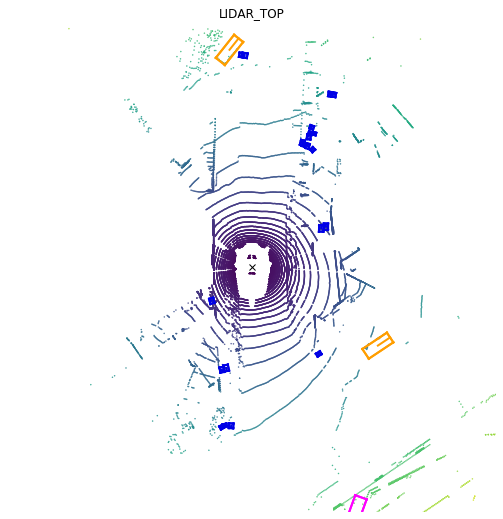

In [11]:
nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=1)

In [110]:
# token = sample['data']['LIDAR_TOP']
# A = nusc.get('sample_data', token)
# nusc.get('ego_pose', A['ego_pose_token'])['translation']
# A.values()

dict_values(['7253c134ac3e4e0fb1334cc8a4fe9286', '410dea74acf640189bdf89c5b0f64265', '7253c134ac3e4e0fb1334cc8a4fe9286', 'fee0c9fadf67432ba60446a69f51d798', 1531885619448111, 'pcd', True, 0, 0, 'samples/LIDAR_TOP/n015-2018-07-18-11-41-49+0800__LIDAR_TOP__1531885619448111.pcd.bin', '8af3da909a6c4e6e9a4cebe166536071', 'd0b5da898edd4d6287ea7219b51e9710', 'lidar', 'LIDAR_TOP'])

In [15]:
# print('example translation:', example['annos'][0]['boxes'][0])
# ego_pose_translation = np.asarray(nusc.get('ego_pose', A['ego_pose_token'])['translation'])
# sample_translation = np.asarray(nusc.get('sample_annotation', sample['anns'][0])['translation'])
# print('sample translation', sample_translation - ego_pose_translation)

example translation: [ 9.1079855  19.809221   -0.44882968  0.553       0.808       1.655
  0.5658678   0.9126065  -2.8520045 ]
sample translation [-11.98573975  19.21264202   0.912     ]


In [17]:
from det3d.models import build_detector
from det3d.torchie.trainer.checkpoint import load_checkpoint

model_file = '/home/image/ohs/Det3D/experiments/hpc_experiments/baselines/cbgs/resnet/epoch_10.pth'

model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.eval()
print(torch.norm(next(model.parameters())))
load_checkpoint(model, model_file)
print(torch.norm(next(model.parameters())))

tensor(0.9961, grad_fn=<NormBackward0>)
tensor(22.1841, grad_fn=<NormBackward0>)


In [18]:
example = next(iter(nusc_val_loader)) 
print(next(model.parameters()).device)

cpu


In [19]:
with torch.no_grad():
    predictions = model(example,return_loss=False)

In [20]:
bboxs = predictions[0]['box3d_lidar']
print(bboxs.shape)

torch.Size([30, 9])


In [22]:
def plot_boxes(boxes, scores, threshold):
    for (bbox, score) in zip(boxes, scores):
        if score < threshold:
            continue
        center = np.asarray(bbox[:2])
        dims = np.asarray(bbox[3:5])/2
        lines = [[center + pm* dims, center + pm*sec_pm * dims * np.asarray([-1,1])] for pm in [-1,1] for sec_pm in [-1,1]]
        lines_xx_yy = [[[line[0][i], line[1][i]] for i in range(2)] for line in lines]
        for line in lines_xx_yy:
            plt.plot(*line, color='r')
    plt.show()

### Simple plotting function of predictions

In [96]:
# plot_boxes(predictions[1]['box3d_lidar'], predictions[1]['scores'], 0.25)

In [64]:
sample_token, box_attrs = next(iter(nusc_annos['results'].items()))
det_boxes = [get_detection_box(box_attr) for box_attr in box_attrs]
gt_boxes = [get_box(nusc.get('sample_annotation', anno)) for anno in A['anns']]

### Simple test for bbox rendering

In [97]:
# _, ax = plt.subplots(1, 1, figsize=(9, 9))
# det_boxes[1].render(ax, view=np.eye(4), colors=('g', 'g', 'g'), linewidth=2)

In [169]:

import numpy as np
from matplotlib import pyplot as plt
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from pyquaternion import Quaternion
import itertools
import inference_utils

Axis = Any

def get_detection_box(record):
    return Box(record['translation'], record['size'], Quaternion(record['rotation']),
                   name=record['detection_name'], token=record['sample_token'])

def get_box(record):
    return Box(record['translation'], record['size'], Quaternion(record['rotation']),
                   name=record['category_name'], token=record['sample_token'])



def boxes_to_sensor(boxes, pose_record, cs_record):
    """
    Map boxes from global coordinates to the vehicle's sensor coordinate system.
    :param boxes: The boxes in global coordinates.
    :param pose_record: The pose record of the vehicle at the current timestamp.
    :param cs_record: The calibrated sensor record of the sensor.
    :return: The transformed boxes.
    """
    boxes_out = []
    for box in boxes:
        # Create Box instance.
        box = Box(box.center, box.wlh, Quaternion(box.orientation))

        # Move box to ego vehicle coord system.
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        boxes_out.append(box)

    return boxes_out

In [170]:
import json
from typing import Any



def visualize_sample(nusc: NuScenes,
                     sample_token: str,
                     gt_boxes,
                     pred_boxes,
                     scores,
                     nsweeps: int = 1,
                     conf_th: float = 0.15,
                     eval_range: float = 50,
                     verbose: bool = True,
                     savepath: str = None) -> None:
    """
    Visualizes a sample from BEV with annotations and detection results.
    :param nusc: NuScenes object.
    :param sample_token: The nuScenes sample token.
    :param gt_boxes: Ground truth boxes grouped by sample.
    :param pred_boxes: Prediction grouped by sample.
    :param nsweeps: Number of sweeps used for lidar visualization.
    :param conf_th: The confidence threshold used to filter negatives.
    :param eval_range: Range in meters beyond which boxes are ignored.
    :param verbose: Whether to print to stdout.
    :param savepath: If given, saves the the rendering here instead of displaying.
    """
    # Retrieve sensor & pose records.
    sample_rec = nusc.get('sample', sample_token)
    sd_record = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    # Get boxes.
#     boxes_gt_global = gt_boxes[sample_token]
#     boxes_est_global = pred_boxes[sample_token]
    boxes_gt_global = gt_boxes
    boxes_est_global = pred_boxes

    # Map GT boxes to lidar.
    boxes_gt = boxes_to_sensor(boxes_gt_global, pose_record, cs_record)

    # Map EST boxes to lidar.
    boxes_est = boxes_to_sensor(boxes_est_global, pose_record, cs_record)

#     # Add scores to EST boxes.
#     for box_est, box_est_global in zip(boxes_est, boxes_est_global):
#         box_est.score = box_est_global.detection_score

    # Get point cloud in lidar frame.
    pc, _ = LidarPointCloud.from_file_multisweep(nusc, sample_rec, 'LIDAR_TOP', 'LIDAR_TOP', nsweeps=nsweeps)

    # Init axes.
    %matplotlib notebook
    _, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Show point cloud.
    points = view_points(pc.points[:3, :], np.eye(4), normalize=False)
    dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
    colors = np.minimum(1, dists / eval_range)
    ax.scatter(points[0, :], points[1, :], c=colors, s=4)

    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='black')

    # Show GT boxes.
    for box in boxes_gt:
        box.render(ax, view=np.eye(4), colors=('g', 'g', 'g'), linewidth=2)

    # Show EST boxes.
    for (box,score) in zip(boxes_est,scores):
        # Show only predictions with a high score.
#         assert not np.isnan(box.score), 'Error: Box score cannot be NaN!'
        if score >= conf_th:
            box.render(ax, view=np.eye(4), colors=('b', 'b', 'b'), linewidth=1)

    # Limit visible range.
    axes_limit = eval_range + 3  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    # Show / save plot.
    if verbose:
        print('Rendering sample token %s' % sample_token)
    plt.title(sample_token)
    if savepath is not None:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

In [162]:
def visualize_prediction(nusc, model_pred, index=0,conf_th=0.15):
    nusc_annos = inference_utils.get_nusc_style(model_pred, nusc) # convert into sample annos style object
    sample_token, det_annotations_attrs = next(itertools.islice(nusc_annos['results'].items(), index, None)) # take a single frame
    scores = model_pred[index]['scores']
    
    det_boxes = [get_detection_box(det_annotation_attr) for det_annotation_attr in det_annotations_attrs] #convert annos-style object into Box object
    annotations_list =nusc.get('sample',sample_token)['anns']
    gt_boxes = [get_box(nusc.get('sample_annotation', anno)) for anno in annotations_list]
    
    visualize_sample(nusc, sample_token, gt_boxes=gt_boxes, pred_boxes=det_boxes, scores=scores, conf_th=conf_th, nsweeps=10) # plot

## visualizaing prediction from detection


In [167]:
# visualize_sample(nusc, sample_token, gt_boxes=gt_boxes, pred_boxes=det_boxes, nsweeps=10)
# visualize_prediction(nusc, predictions, 1)